In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
from torch.utils.data import Dataset, DataLoader
from torch._tensor import Tensor

sns.set_style(style="whitegrid")

In [46]:
TICKER = "AAPL"
START_DATE = "2000-01-01"
END_DATE = "2024-01-01"
LOOKBACK_WINDOW = 60
FORECAST_HORIZON = 5


def get_features(df: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    """Generate features for the financial data DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame with financial data.
        window (int, optional): The rolling window size for volatility calculation. Defaults to 20.
    Returns:
        pd.DataFrame: The DataFrame with additional features.
    """
    df = df[["Close", "Volume"]].copy()

    df["Log_Ret"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Volatility"] = df["Log_Ret"].rolling(window=window).std()
    df["Log_Vol_Chg"] = np.log((df["Volume"] + 1e-9) / (df["Volume"].shift(1) + 1e-9))

    df.dropna(inplace=True)
    return df


def get_financial_data(ticker: str, start: str, end: str) -> pd.DataFrame:
    """Fetch historical financial data for a specific ticker.

    Args:
        ticker (str): The stock ticker symbol.
        start (str): The start date for the data (YYYY-MM-DD).
        end (str): The end date for the data (YYYY-MM-DD).

    Returns:
        pd.DataFrame: A DataFrame containing the historical financial data.
    """

    print(f"Stock: {ticker}")
    df = yf.download(ticker, start=start, end=end, auto_adjust=True)
    
    return df


df = get_financial_data(TICKER, START_DATE, END_DATE)
df = get_features(df)
df[:10]

[*********************100%***********************]  1 of 1 completed

Stock: AAPL


Price,Close,Volume,Log_Ret,Volatility,Log_Vol_Chg
Ticker,AAPL,AAPL,,,
Date,,,,,
2000-02-01,0.751650,318035200,-0.034317,0.054474,-0.791315
2000-02-02,0.740872,464195200,-0.014443,0.050977,0.378143
2000-02-03,0.774613,475193600,0.044535,0.051916,0.023417
2000-02-04,0.809758,425320000,0.044373,0.048214,-0.110880
2000-02-07,0.855213,441067200,0.054615,0.048611,0.036355
2000-02-08,0.861306,408643200,0.007099,0.048266,-0.076355
2000-02-09,0.844435,299364800,-0.019782,0.046631,-0.311180
2000-02-10,0.850996,302982400,0.007740,0.043503,0.012012


<Axes: title={'center': 'AAPL Closing Prices'}, xlabel='Date'>

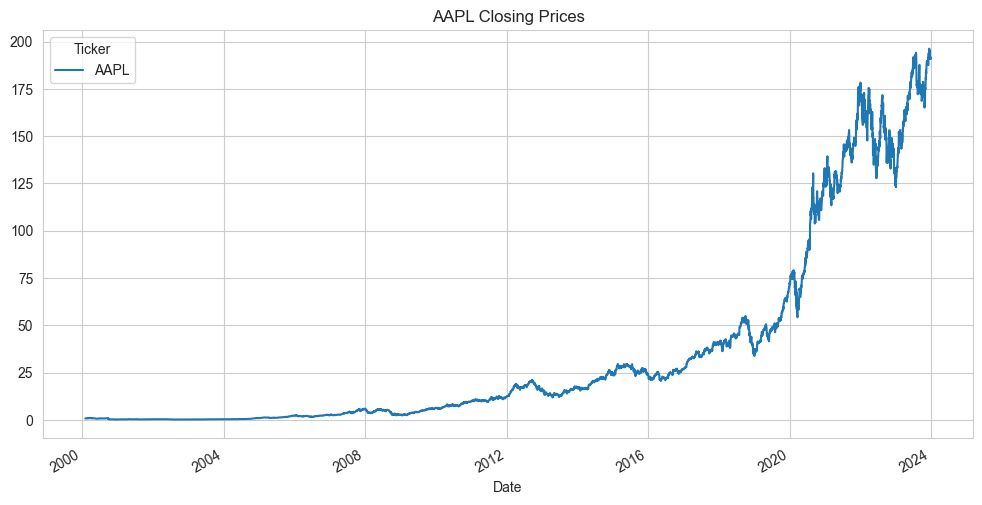

In [47]:
df["Close"].plot(title=f"{TICKER} Closing Prices", figsize=(12, 6))

array([[<Axes: title={'center': "('Close', 'AAPL')"}>,
        <Axes: title={'center': "('Volume', 'AAPL')"}>],
       [<Axes: title={'center': "('Log_Ret', '')"}>,
        <Axes: title={'center': "('Volatility', '')"}>],
       [<Axes: title={'center': "('Log_Vol_Chg', '')"}>, <Axes: >]],
      dtype=object)

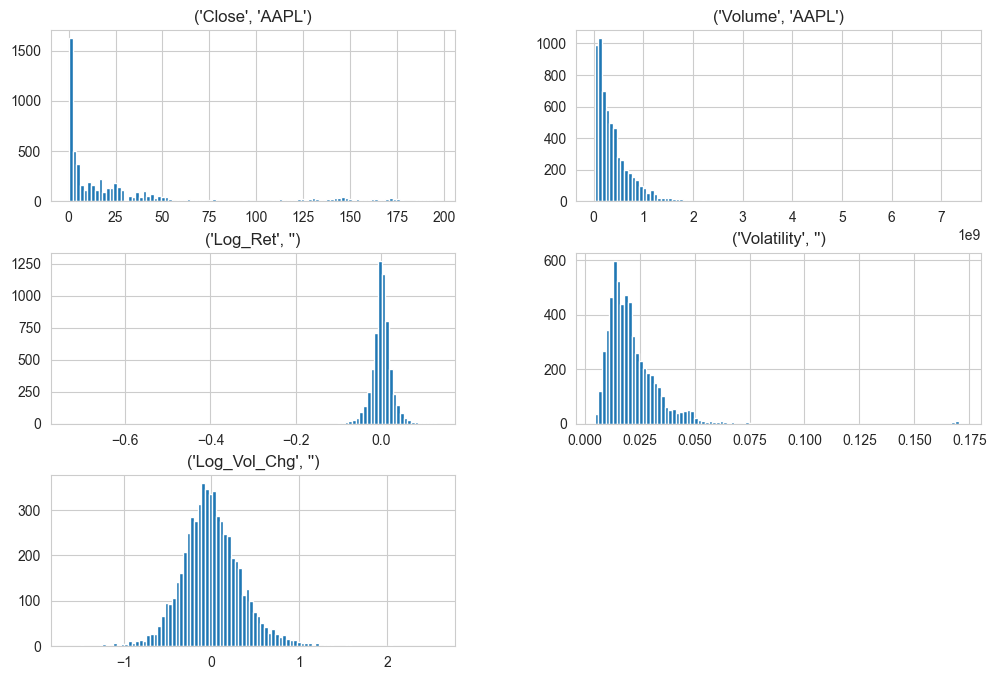

In [48]:
df.hist(bins=100, figsize=(12, 8))

In [49]:
# pd.DataFrame(X_raw[0], columns=['log_ret', 'volatility', 'rel_vol']).hist(bins=20, figsize=(8, 6))

In [50]:
def create_sequences(data:pd.DataFrame, lookback: int, horizon: int) -> tuple[np.ndarray, np.ndarray]:
    """Create sequences of data for time series forecasting.

    Args:
        data (pd.DataFrame): The input data containing features.
        lookback (int): The number of past timesteps to include in each input sequence.
        horizon (int): The number of future timesteps to predict.

    Returns:
        Tuple[np.ndarray, np.ndarray]: The input sequences (X) and the corresponding targets (y).
    """
    X, y = [], []

    feature_cols = ['Log_Ret', 'Volatility', 'Log_Vol_Chg']
    data_values = data[feature_cols].values

    for i in range(len(data) - lookback - horizon):
        window = data_values[i : i + lookback]
        future_window = data_values[i + lookback : i + lookback + horizon, 0]

        X.append(window)
        y.append(future_window)

    
    return np.array(X), np.array(y)

X_raw, y_raw = create_sequences(df, LOOKBACK_WINDOW, FORECAST_HORIZON)

print(f"Created {X_raw.shape[0]} sequences.")
print(f"X shape: {X_raw.shape}  (Samples, Timesteps, Features)")
print(f"y shape: {y_raw.shape}  (Samples, Horizon)")

Created 5952 sequences.
X shape: (5952, 60, 3)  (Samples, Timesteps, Features)
y shape: (5952, 5)  (Samples, Horizon)


$$x_t' = \frac{x_t - \mu_{window}}{\sigma_{window} + \epsilon}$$

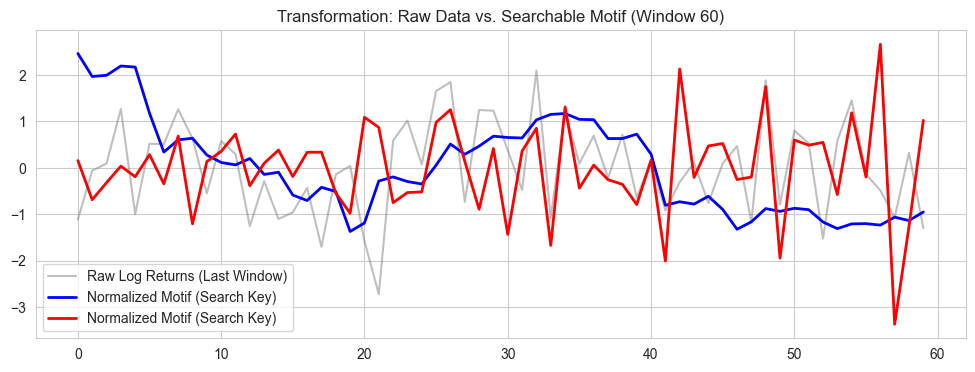

In [51]:
def normalize_windows(X: np.ndarray):
    """Normalize the input windows using Z-score normalization.

    Args:
        X (np.ndarray): The input data windows.

    Returns:
        tuple: A tuple containing the normalized windows, means, and standard deviations.
    """
    # Calculate Mean and Std along the time axis (axis 1)
    # keepdims=True ensures shapes broadcast correctly: (N, 1, F)
    means: np.float64 = np.mean(X, axis=1, keepdims=True)
    stds: np.float64 = np.std(X, axis=1, keepdims=True)

    # Division by zero with a small epsilon
    epsilon = 1e-8

    X_norm = (X - means) / (stds + epsilon)

    return X_norm, means, stds


X_norm, X_means, X_stds = normalize_windows(X_raw)

# Verification Plot
plt.figure(figsize=(12, 4))
plt.plot(
    X_norm[-1, :, 0], label="Raw Log Returns (Last Window)", color="gray", alpha=0.5
)
plt.plot(
    X_norm[-1, :, 1], label="Normalized Motif (Search Key)", color="blue", linewidth=2
)
plt.plot(
    X_norm[-1, :, 2], label="Normalized Motif (Search Key)", color="red", linewidth=2
)
plt.title(f"Transformation: Raw Data vs. Searchable Motif (Window {LOOKBACK_WINDOW})")
plt.legend()
plt.show()

In [52]:
N, T, F = X_norm.shape
d = F * T

print(f"N (Samples): {N}, T (Timesteps): {T}, F (Features): {F}")
print(f"d (Dimension): {d}")

# Float32 for Faiss
X_flat = X_norm.reshape(N, d).astype('float32')
print(f"X_flat shape: {X_flat.shape}")

index = faiss.IndexFlatL2(d) 
index.add(X_flat)

print(f"Number of vectors in the index: {index.ntotal}")
print(f"Training status: {index.is_trained}")

N (Samples): 5952, T (Timesteps): 60, F (Features): 3
d (Dimension): 180
X_flat shape: (5952, 180)
Number of vectors in the index: 5952
Training status: True


In [53]:
q_id = 900
query_vector = X_flat[q_id].reshape(1, -1)
print(query_vector.shape)
query_vector[0,:3]

(1, 180)


array([ 0.24602124, -0.84328294,  0.29727066], dtype=float32)

In [54]:
k = 5
distances, indices = index.search(query_vector, k)

print("\n--- Retrieval Results ---")
print(f"Query Index: {q_id}")
print(f"Found Match Indices: {indices[0]}")
print(f"Similarity Scores (L2 Dist): {distances[0]}")


--- Retrieval Results ---
Query Index: 900
Found Match Indices: [ 900 3556 1984 4514 1718]
Similarity Scores (L2 Dist): [  0.      183.39766 194.92336 195.19101 203.29437]


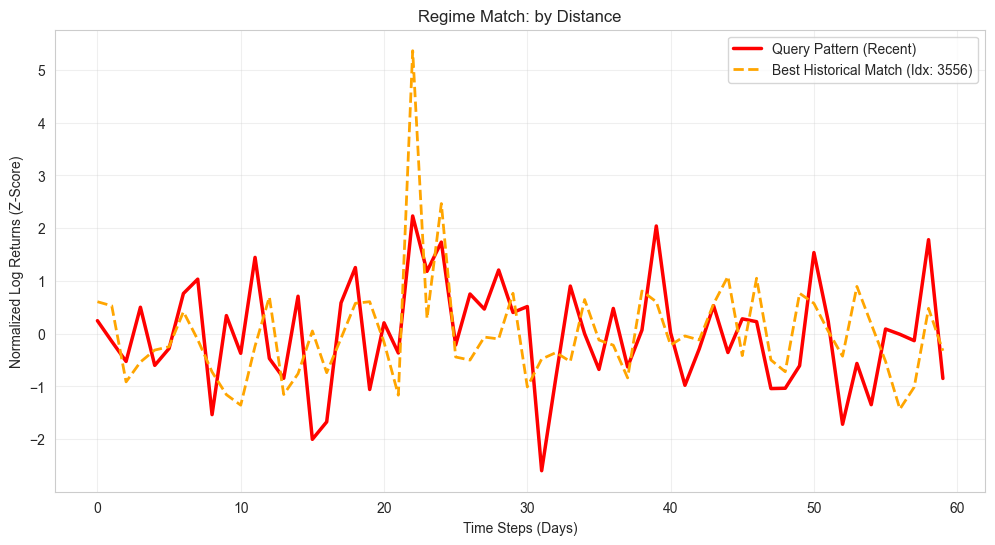

In [56]:
f = 0
plt.figure(figsize=(12, 6))
plt.plot(X_norm[q_id,:,f], label='Query Pattern (Recent)', color='red', linewidth=2.5)

plt.plot(X_norm[indices[0][1], :, f], label=f'Best Historical Match (Idx: {indices[0][1]})', 
         color='orange', linestyle='--', linewidth=2)


# plt.plot(X_norm[indices[0][2], :, 0], label=f'2nd Best Historical Match (Idx: {indices[0][2]})', 
#          color='gray', linestyle='--', linewidth=2w)
plt.title(f"Regime Match: by Distance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel("Normalized Log Returns (Z-Score)")
plt.xlabel("Time Steps (Days)")
plt.show()